<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import plotly.express as px
%matplotlib inline

#importing the libraries needed for classification

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

<h3> Read in the data, store if dataframe

In [59]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [60]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [61]:
m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

<h4>Binning

In [62]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

<h4>Mapping

In [63]:
work_type_map = {
    'private':0,
    'self-employed':1,
    'govt-job':2,
    'children':3,
    'never-worked':4
}
residence_type_map = {
    'urban':0,
    'rural':1
}
smoking_status_map = {
    'formerly-smoked':0,
    'never-smoked':1,
    'smokes':2,
    'unknown':3
}

df['work_type'] = df['work_type'].map(work_type_map)
df['residence_type'] = df['residence_type'].map(residence_type_map)
df['smoking_status'] = df['smoking_status'].map(smoking_status_map)

In [64]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,1,67,0,1,1,0,0,228.69,36.6,0,1,"(65.0, 75.0]","(192.2, 271.7]","(34.2, 38.6]"
1,51676,0,61,0,0,1,1,1,202.21,29.1,1,1,"(57.0, 65.0]","(192.2, 271.7]","(28.2, 29.9]"
2,31112,1,80,0,1,1,0,1,105.92,32.5,1,1,"(75.0, 82.0]","(98.9, 108.5]","(31.8, 34.2]"
3,60182,0,49,0,0,1,0,0,171.23,34.4,2,1,"(45.0, 51.0]","(124.1, 192.2]","(34.2, 38.6]"
4,1665,0,79,1,0,1,1,1,174.12,24.0,1,1,"(75.0, 82.0]","(124.1, 192.2]","(22.6, 24.7]"


# Change category variable since matplotlib cant handle categories

In [65]:
df['bmi_bin'] = df['bmi_bin'].cat.codes
df['age_bin'] = df['age_bin'].cat.codes
df['avg_glucose_level_bin'] = df['avg_glucose_level_bin'].cat.codes

# Split data and set variables 

In [66]:
#This is a simple knn classification on face value of all featured columns
Xvar = df.drop(['gender','hypertension','heart_disease','ever_married','residence_type','smoking_status',
                'age','stroke','work_type','bmi','avg_glucose_level'],axis=1)
Yvar = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(Xvar, Yvar, test_size=0.3)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=1,p=2,metric='euclidean')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1459
           1       0.12      0.15      0.13        74

    accuracy                           0.91      1533
   macro avg       0.54      0.55      0.54      1533
weighted avg       0.92      0.91      0.91      1533



### Confusion matrix for Knn classifier

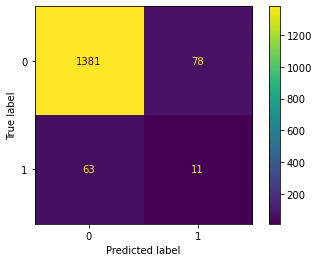

In [67]:
plot_confusion_matrix(classifier, X_test, y_test)

### Setting new variables for testing one with and without smote

In [68]:
X = df.drop(['id','gender','ever_married','work_type','residence_type','smoking_status','age_bin','stroke','bmi'],axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#and smote down here
smote = SMOTE(sampling_strategy=0.6)
X_trainS , y_trainS = smote.fit_resample(X_train,y_train)


### Without Smote

In [69]:
nonsmote = pd.DataFrame(index = ['avg accuracy','avg recall','avg precision','avg quality','F1-score'])
Knn = [1,2,3,4,5,6,7,8,9,10]
for index in Knn :
    pipe = Pipeline([('Scaler',StandardScaler()),('Classifier',KNeighborsClassifier(n_neighbors=index))])
    #index is 6 so shape must match
    arr = np.zeros(5)
    for j in range(5) :
        X_fit, X_tf, y_fit, y_tf = train_test_split(X_train, y_train, test_size=0.30)
        pipe.fit(X_fit,y_fit)
        predictions = pipe.predict(X_tf)
        accuracy = np.mean(predictions==y_tf) 
        TP = np.sum(np.array(predictions ==1))
        TN = np.sum(np.array(predictions ==0))
        FP = np.sum(np.array(predictions ==1))
        FN = np.sum(np.array(predictions ==0))
        if TP==0 and FP==0:
            precision = 0
        else : 
            precision = TP/(TP+FP)
        arr = arr + np.array([accuracy,TP/(TP+FN),precision,TN/(TN+FP),2*(precision*TP/(TP+FN))/(precision+(TP/(TP+FN)))])
    arr = arr/5
    nonsmote[str(f'{index}')] = arr

In [70]:
nonsmote

,1,2,3,4,5,6,7,8,9,10
avg accuracy,0.916869,0.946505,0.940168,0.955638,0.945760,0.951724,0.946132,0.948928,0.950233,0.949860
avg recall,0.046226,0.005778,0.015098,0.003169,0.012116,0.001491,0.003914,0.003169,0.003355,0.000746
avg precision,0.500000,0.500000,0.500000,0.400000,0.500000,0.500000,0.500000,0.500000,0.400000,0.300000
avg quality,0.953774,0.994222,0.984902,0.996831,0.987884,0.998509,0.996086,0.996831,0.996645,0.999254
F1-score,0.084563,0.011409,0.029262,NaN,0.023620,0.002971,0.007756,0.006287,NaN,NaN


### With smote

In [71]:
smoteresults = pd.DataFrame(index = ['avg accuracy','avg recall','avg precision','avg quality','F1-score'])
Knn = [1,2,3,4,5,6,7,8,9,10]
for index in Knn :
    pipe = Pipeline([('Scaler',StandardScaler()),('Classifier',KNeighborsClassifier(n_neighbors=index))])
    #index is 5 so shape must match
    arr = np.zeros(5)
    for j in range(5) :
        X_fit, X_tf, y_fit, y_tf = train_test_split(X_trainS, y_trainS, test_size=0.3)
        pipe.fit(X_fit,y_fit)
        predictions = pipe.predict(X_tf)
        accuracy = np.mean(predictions==y_tf) 
        TP = np.sum(np.array(predictions ==1))
        TN = np.sum(np.array(predictions ==0))
        FP = np.sum(np.array(predictions ==1))
        FN = np.sum(np.array(predictions ==0))
        if TP==0 and FP==0:
            precision = 0
        else : 
            precision = TP/(TP+FP)
        arr = arr + np.array([accuracy,TP/(TP+FN),precision,TN/(TN+FP),2*(precision*TP/(TP+FN))/(precision+(TP/(TP+FN)))])
    arr = arr/5
    smoteresults[str(f'{index}')] = arr

In [72]:
smoteresults

,1,2,3,4,5,6,7,8,9,10
avg accuracy,0.868666,0.871603,0.858629,0.857772,0.846267,0.845900,0.839168,0.831824,0.835373,0.825949
avg recall,0.409425,0.346267,0.418360,0.394125,0.433537,0.393758,0.446389,0.414443,0.435985,0.409180
avg precision,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
avg quality,0.590575,0.653733,0.581640,0.605875,0.566463,0.606242,0.553611,0.585557,0.564015,0.590820
F1-score,0.450167,0.409116,0.455541,0.440771,0.464363,0.440360,0.471638,0.453150,0.465788,0.449944


# Using the pipeline to ensure data constraints

In [73]:
print("Smote")
pipe = Pipeline([('Scaler',StandardScaler()),('Classifier',KNeighborsClassifier(n_neighbors=1))])
pipe.fit(X_trainS,y_trainS)
predictions_test = pipe.predict(X_test)
print(confusion_matrix(y_test,predictions_test))
print('\n')
print(classification_report(y_test,predictions_test))

print("Non Smote")
pipe = Pipeline([('Scaler',StandardScaler()),('Classifier',KNeighborsClassifier(n_neighbors=1))])
pipe.fit(X_train,y_train)
predictions = pipe.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))


Smote
[[1274  183]
 [  50   26]]


              precision    recall  f1-score   support

           0       0.96      0.87      0.92      1457
           1       0.12      0.34      0.18        76

    accuracy                           0.85      1533
   macro avg       0.54      0.61      0.55      1533
weighted avg       0.92      0.85      0.88      1533

Non Smote
[[1386   71]
 [  62   14]]


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1457
           1       0.16      0.18      0.17        76

    accuracy                           0.91      1533
   macro avg       0.56      0.57      0.56      1533
weighted avg       0.92      0.91      0.92      1533



### using pipeline

In [74]:
pipe = Pipeline([('Scaler',StandardScaler()),('Classifier',KNeighborsClassifier(n_neighbors=5))])
pipe.fit(X_trainS,y_trainS)
predictions = pipe.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))


[[1222  235]
 [  41   35]]


              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1457
           1       0.13      0.46      0.20        76

    accuracy                           0.82      1533
   macro avg       0.55      0.65      0.55      1533
weighted avg       0.93      0.82      0.86      1533



### no pipeline

In [75]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[[1396   61]
 [  69    7]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1457
           1       0.10      0.09      0.10        76

    accuracy                           0.92      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.91      0.92      0.91      1533



### Using an skf function from member to check data

In [76]:
skf = StratifiedKFold(shuffle=True, n_splits=10)
def run_skfold(model, X, y):
    split = 0
    accuracy = []
    recall = []
    precision = []
    f1 = []
    false_negative = []
    false_positive = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train_split, X_test_split = X.iloc[train_idx.tolist()], X.iloc[test_idx.tolist()]
        y_train_split, y_test_split = y.iloc[train_idx.tolist()], y.iloc[test_idx.tolist()]
        X_train_res, y_train_res = SMOTE().fit_resample(X_train_split, y_train_split)
        model.fit(X_train_res, y_train_res)
        y_pred_split = model.predict(X_test_split)
        y_prob_split = model.predict_proba(X_test_split)[:,1]
        print("Experiment:", split)
        print("Classification Report")
        print(classification_report(y_test_split, y_pred_split))
        
        print("Confusion Matrix")
        cm = confusion_matrix(y_test_split, y_pred_split)
        
        print(f"True positive: {cm[0][0]}")
        print(f"True negative: {cm[1][1]}")
        print(f"False positive: {cm[0][1]}")
        print(f"False negative: {cm[1][0]}")
        print("\n")
        
        
        report = classification_report(y_test_split, y_pred_split, output_dict=True)
        
        accuracy.append(report['accuracy'])
        recall.append(report['macro avg']['recall'])
        precision.append(report['macro avg']['precision'])
        f1.append(report['macro avg']['f1-score'])
        false_negative.append(cm[1][0])
        false_positive.append(cm[0][1])
        
        split += 1
    
    print("Mean test results:")
    print(f"Mean accuracy: {round(np.mean(accuracy), 2)}")
    print(f"Mean macro avg recall: {round(np.mean(recall), 2)}")
    print(f"Mean macro avg precision: {round(np.mean(precision), 2)}")
    print(f"Mean macro avg f1: {round(np.mean(f1), 2)}")
    print(f"Mean false negative: {round(np.mean(false_negative), 2)}")
    print(f"Mean false positive: {round(np.mean(false_positive), 2)}")

In [77]:
### Reslts of function call

In [78]:
run_skfold(pipe, X, y)

Experiment: 0
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       486
           1       0.10      0.40      0.16        25

    accuracy                           0.79       511
   macro avg       0.53      0.61      0.52       511
weighted avg       0.92      0.79      0.85       511

Confusion Matrix
True positive: 394
True negative: 10
False positive: 92
False negative: 15


Experiment: 1
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       486
           1       0.09      0.32      0.13        25

    accuracy                           0.80       511
   macro avg       0.52      0.57      0.51       511
weighted avg       0.92      0.80      0.85       511

Confusion Matrix
True positive: 400
True negative: 8
False positive: 86
False negative: 17


Experiment: 2
Classification Report
              precision    recall  f1-score   suppo

### KNN with stratified k fold

In [79]:
classifier = KNeighborsClassifier(n_neighbors=1,p=2,metric='euclidean')
skf = StratifiedKFold(shuffle=True, n_splits=10)
scores = cross_val_score(pipe, X_trainS, y_trainS, cv=skf)
print(scores)

[0.88073394 0.87522936 0.87155963 0.84220183 0.84926471 0.84926471
 0.84007353 0.86764706 0.875      0.85110294]


In [80]:
classifier = KNeighborsClassifier(n_neighbors=1,p=2,metric='euclidean')
skf = StratifiedKFold(shuffle=True, n_splits=10)
scores = cross_val_score(pipe, X_train, y_train, cv=skf)

print(scores)

[0.94972067 0.94692737 0.94134078 0.94972067 0.93854749 0.94692737
 0.94957983 0.95238095 0.94117647 0.94957983]


### Testing f1 score and accuracy of Knn

In [81]:
Xvar = df.drop(['age'],axis=1)
Yvar = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(Xvar, Yvar, test_size=0.3)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=1,p=2,metric='euclidean')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print("F-1 score: ",f1_score(y_test, y_pred))
print("Accuracy: ",accuracy_score(y_test, y_pred))


F-1 score:  1.0
Accuracy:  1.0


### Knn results with Smote

In [82]:
X = df.drop(['age'],axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#and smote down here
smote = SMOTE(sampling_strategy=0.6)
X_trainS , y_trainS = smote.fit_resample(X_train,y_train)

#no pipe
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_trainS, y_trainS)
predictions = classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[[1112  348]
 [  50   23]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1460
           1       0.06      0.32      0.10        73

    accuracy                           0.74      1533
   macro avg       0.51      0.54      0.48      1533
weighted avg       0.91      0.74      0.81      1533



In [83]:
print("Smote")
pipe = Pipeline([('Scaler',StandardScaler()),('Classifier',KNeighborsClassifier(n_neighbors=1))])
pipe.fit(X_trainS,y_trainS)
predictions_test = pipe.predict(X_test)
print(confusion_matrix(y_test,predictions_test))
print('\n')
print(classification_report(y_test,predictions_test))

Smote
[[1459    1]
 [   8   65]]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1460
           1       0.98      0.89      0.94        73

    accuracy                           0.99      1533
   macro avg       0.99      0.94      0.97      1533
weighted avg       0.99      0.99      0.99      1533

